# Нейросеть для автодополнения текстов

## Этап 1. Сбор и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import evaluate as eval_metric
import re
import html
import math
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.utils.tensorboard import SummaryWriter

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.processors import TemplateProcessing

from tqdm import tqdm
from datetime import datetime

from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments,
    DataCollatorForLanguageModeling,
    get_scheduler
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig


C:\Users\Andrey\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Чтение файла как списка строк
with open("data/raw_data.csv", "r", encoding="latin-1") as file:
    lines = file.readlines()

# Создание DataFrame с одним столбцом 'text'
df = pd.DataFrame({'text': lines})

# Удаление символов переноса строк в конце каждой строки
df['text'] = df['text'].str.strip()

df.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.info(), df.shape
df = df[:10000]  # Ограничение для ускорения обучения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600498 entries, 0 to 1600497
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600498 non-null  object
dtypes: object(1)
memory usage: 12.2+ MB


In [4]:
# --- простая очистка ---
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = html.unescape(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' <URL> ', text)  # ссылки
    text = re.sub(r'@\w+', ' <USER> ', text)             # упоминания
    text = re.sub(r'\brt\b', ' ', text)                  # retweet
    text = re.sub(r"[^a-z0-9а-яё\s\.\,\!\?\:\;\-\']+", ' ', text)  # убираем мусор
    text = re.sub(r'\s+', ' ', text).strip()             # убираем лишние пробелы
    return text

texts = df['text'].astype(str).tolist()
cleaned = [clean_text(t) for t in tqdm(texts, desc="Cleaning texts")]

df_clean = pd.DataFrame({"text": cleaned})
df_clean.to_csv("data/cleaned.csv", index=False, encoding="utf-8")

print("Сохранено:", "data/cleaned.csv", " (строк:", len(df_clean), ")")

Cleaning texts: 100%|██████████| 10000/10000 [00:00<00:00, 180173.12it/s]

Сохранено: data/cleaned.csv  (строк: 10000 )


**Основные этапы обработки данных:**

- **Очистка текста (`clean_text`):**
    - Декодирует HTML-сущности
    - Приводит к нижнему регистру
    - Заменяет URL на `<URL>`
    - Заменяет упоминания на `<USER>`
    - Удаляет RT
    - Оставляет буквы, цифры и знаки препинания
    - Убирает лишние пробелы

- **Сохранение результата:**
    - Создаёт DataFrame с очищенными текстами и метками
    - Сохраняет в `data/cleaned.csv`

**Результат:**  
Очищенный датасет для обучения моделей, анализа тональности и других NLP-задач.



=== Мини-EDA ===
Всего текстов: 10000
Средняя длина (символы): 67.6337
Медиана длины (символы): 63.0
Средняя длина (токены): 13.1937
Медиана длины (токены): 12.0
95-й перцентиль (токены): 25.0


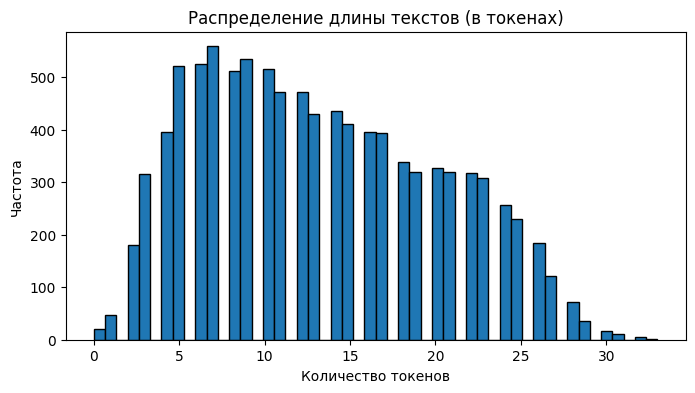

In [5]:
# --- Мини-EDA ---
df_clean["len_chars"] = df_clean["text"].apply(len)
df_clean["len_tokens"] = df_clean["text"].apply(lambda x: len(x.split()))

print("\n=== Мини-EDA ===")
print("Всего текстов:", len(df_clean))
print("Средняя длина (символы):", df_clean["len_chars"].mean())
print("Медиана длины (символы):", df_clean["len_chars"].median())
print("Средняя длина (токены):", df_clean["len_tokens"].mean())
print("Медиана длины (токены):", df_clean["len_tokens"].median())

# 95-й перцентиль — полезен для выбора max_len
print("95-й перцентиль (токены):", np.percentile(df_clean["len_tokens"], 95))

# --- Гистограмма ---
plt.figure(figsize=(8,4))
plt.hist(df_clean["len_tokens"], bins=50, edgecolor="black")
plt.title("Распределение длины текстов (в токенах)")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()

## Этапы 2 и 3. Объявление модели LSTM и тренировка модели

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f'runs_lstm/text_generation_{timestamp}')

# ========== ШАГ 1: Токенизация ==========

print("Обучение BPE токенизатора...")

# Используем 90-й перцентиль + запас для специальных токенов
max_length = int(np.percentile(df_clean["len_tokens"], 90)) + 10  # +10 для запаса

print(f"Установка max_length = {max_length} на основе 90-го перцентиля")

tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.Whitespace(),
    pre_tokenizers.Punctuation(),
    pre_tokenizers.Digits(individual_digits=True)
])
trainer = trainers.BpeTrainer(
    vocab_size=30000,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
    min_frequency=2
)
tokenizer.train_from_iterator(
    df_clean["text"].apply(str), 
    trainer=trainer
)
tokenizer.post_processor = TemplateProcessing(
    single="<s> $A </s>",
    special_tokens=[("<s>", 2), ("</s>", 3)]
)
tokenizer.enable_padding(pad_id=0, pad_token="<pad>")
tokenizer.enable_truncation(max_length=max_length)  # ← Используем вычисленное значение

# Сохранение токенизатора
tokenizer.save("data/tokenizer.json")
print("Токенизатор обучен и сохранен")

# ========== ШАГ 2: Подготовка данных (X, Y) ==========
def encode_texts(texts):
    return [tokenizer.encode(text).ids for text in texts]

print("Кодирование текстов...")
encoded_texts = encode_texts(tqdm(df_clean["text"], desc="Encoding texts"))

# Создание пар (X, Y) - предсказание следующего токена
X = [seq[:-1] for seq in encoded_texts]
Y = [seq[1:] for seq in encoded_texts]

# ========== ШАГ 3: Разделение данных ==========
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

print(f"Размеры выборок:")
print(f"Обучающая: {len(X_train)}")
print(f"Валидационная: {len(X_val)}")
print(f"Тестовая: {len(X_test)}")

# ========== ШАГ 4: Создание Dataset и DataLoader ==========
batch_size = 512

class TextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.Y[idx])

def collate_fn(batch):
    X_batch, Y_batch = zip(*batch)

    # Длина батча
    lengths = [len(x) for x in X_batch]

    # Паддинг X и Y
    X_padded = pad_sequence([torch.tensor(x) for x in X_batch], batch_first=True, padding_value=0)
    Y_padded = pad_sequence([torch.tensor(y) for y in Y_batch], batch_first=True, padding_value=0)

    lengths = torch.tensor(lengths, dtype=torch.long)

    return X_padded, Y_padded, lengths


train_dataset = TextDataset(X_train, Y_train)
val_dataset = TextDataset(X_val, Y_val)
test_dataset = TextDataset(X_test, Y_test)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, collate_fn=collate_fn
)

# ========== ШАГ 5: Определение модели ==========
class ImprovedTextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.4)
        
        # Улучшенная инициализация эмбеддингов
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        nn.init.constant_(self.embedding.weight[0], 0)  # padding токен
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=False
        )
        
        # Layer Normalization для стабилизации обучения
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        
        # Проекционная сеть
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, vocab_size)
        )
        
        self.dropout = nn.Dropout(0.6)
        
        # Простая инициализация LSTM весов
        self._init_weights()
        
    def _init_weights(self):
        # Инициализация весов LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
                
    def forward(self, x, lengths=None, hidden=None):
        x = self.embedding(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.embedding_dropout(x)
        x = self.ln1(x)
        x = self.dropout(x)

        if lengths is not None:
            packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, hidden = self.lstm(packed_x, hidden)
            out, _ = pad_packed_sequence(packed_out, batch_first=True, padding_value=0)
        else:
            out, hidden = self.lstm(x, hidden)

        out = self.ln2(out)
        out = self.dropout(out)
        return self.fc(out), hidden

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.get_vocab_size()
model_lstm = ImprovedTextLSTM(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.01)
optimizer = optim.AdamW(model_lstm.parameters(), lr=0.0005, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5)
scaler = torch.amp.GradScaler("cuda") 

print(f"Модель создана, параметров: {sum(p.numel() for p in model_lstm.parameters()):,}")

# ========== ШАГ 6: Цикл обучения ==========
def train_epoch(model_lstm, loader, optimizer, criterion, device, epoch, scaler):
    model_lstm.train()
    total_loss = 0
    total_tokens = 0
    progress_bar = tqdm(loader, desc=f"Обучение эпоха {epoch+1}")

    for batch_idx, (X_batch, Y_batch, lengths) in enumerate(progress_bar):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=torch.float16):
            output, _ = model_lstm(X_batch, lengths=lengths)
            loss = criterion(output.view(-1, output.shape[-1]), Y_batch.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        current_loss = loss.item()
        total_loss += current_loss * (Y_batch != 0).sum().item()
        total_tokens += (Y_batch != 0).sum().item()

        if batch_idx % 50 == 0:
            writer.add_scalar('Loss/train_batch', current_loss, epoch * len(loader) + batch_idx)
            writer.add_scalar('Perplexity/train_batch', math.exp(current_loss), epoch * len(loader) + batch_idx)

        progress_bar.set_postfix({
            "loss": f"{current_loss:.4f}",
            "ppl": f"{math.exp(current_loss):.2f}",
            "scale": f"{scaler.get_scale():.2f}"
        })

    avg_loss = total_loss / total_tokens if total_tokens > 0 else total_loss / len(loader)
    return avg_loss

def evaluate(model_lstm, loader, criterion, device):
    model_lstm.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for X_batch, Y_batch, lengths in tqdm(loader, desc="Валидация"):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            lengths = lengths.to(device)
            output, _ = model_lstm(X_batch, lengths=lengths)
            loss = criterion(output.view(-1, output.shape[-1]), Y_batch.view(-1))
            
            total_loss += loss.item() * (Y_batch != 0).sum().item()
            total_tokens += (Y_batch != 0).sum().item()
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else total_loss / len(loader)
    return avg_loss

print("Начало обучения...")
best_val_loss = float('inf')
best_epoch = -1
patience = 1
patience_counter = 0

# Инициализация GradScaler
scaler = torch.amp.GradScaler("cuda")  # После определения устройства

def calculate_rouge_evaluate(model_lstm, loader, tokenizer, device, num_samples=1000):
    # Загружаем метрику ROUGE
    rouge = eval_metric.load("rouge")
    
    hypotheses = []
    references = []

    model_lstm.eval()
    with torch.no_grad():
        for i, (X_batch, Y_batch, lengths) in enumerate(tqdm(loader, desc="ROUGE Evaluation")):
            if len(hypotheses) >= num_samples:
                break
                
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            lengths = lengths.to(device)

            # Получаем предсказания модели
            output, _ = model_lstm(X_batch, lengths=lengths)
            predictions = output.argmax(dim=-1)

            for j in range(X_batch.size(0)):
                if len(hypotheses) >= num_samples:
                    break

                # Извлекаем последовательности без паддинга
                pred_seq = predictions[j].cpu().tolist()
                target_seq = Y_batch[j].cpu().tolist()

                # Убираем паддинг и специальные токены
                pred_tokens = [t for t in pred_seq if t not in [0, 2, 3]]  # 0=<pad>, 2=<s>, 3=</s>
                target_tokens = [t for t in target_seq if t not in [0, 2, 3]]

                # Декодируем
                pred_text = tokenizer.decode(pred_tokens)
                target_text = tokenizer.decode(target_tokens)

                if pred_text.strip() and target_text.strip():  # Только непустые тексты
                    hypotheses.append(pred_text)
                    references.append(target_text)

    # Вычисляем метрики
    results = rouge.compute(predictions=hypotheses, references=references)
    return results

# Для графиков matplotlib
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for epoch in range(7):
    train_loss = train_epoch(model_lstm, train_loader, optimizer, criterion, device, epoch, scaler)
    val_loss = evaluate(model_lstm, val_loader, criterion, device)

    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Perplexity/train', train_ppl, epoch)
    writer.add_scalar('Perplexity/val', val_ppl, epoch)
    writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)
    
    # --- Вычисляем ROUGE на валидации ---
    rouge_val = calculate_rouge_evaluate(model_lstm, val_loader, tokenizer, device, num_samples=200)

    print(f"Эпоха {epoch+1}:")
    print(f"  Train Loss = {train_loss:.4f} | Perplexity = {train_ppl:.2f}")
    print(f"  Val Loss = {val_loss:.4f} | Perplexity = {val_ppl:.2f}")
    print(f"  Learning Rate = {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  ROUGE на валидации: ", end="")
    print(", ".join([f"{k}={v:.4f}" for k,v in rouge_val.items()]))

    # --- Сохраняем метрики в списки для графиков ---
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_perplexities.append(train_ppl)
    val_perplexities.append(val_ppl)

    rouge1_scores.append(rouge_val.get("rouge1", 0))
    rouge2_scores.append(rouge_val.get("rouge2", 0))
    rougeL_scores.append(rouge_val.get("rougeL", 0))

    # --- TensorBoard ---
    for metric_name, score in rouge_val.items():
        writer.add_scalar(f'ROUGE/{metric_name}', score, epoch)

    # --- Сохраняем лучшую модель ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'rouge': rouge_val
        }, "models/best_model_lstm.pt")
        print(f"Модель сохранена на эпохе {epoch+1}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Ранняя остановка")
            break

    print("-" * 50)

writer.close()

# ========== ШАГ 7: Генерация текста ==========
def generate_text_topp(model_lstm, tokenizer, prompt, max_length=max_length, temperature=0.7, top_p=0.9):
    model_lstm.eval()
    
    input_ids = tokenizer.encode(prompt, add_special_tokens=False).ids
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    
    generated_tokens = []
    
    with torch.no_grad():
        for _ in range(max_length):
            output, _ = model_lstm(input_tensor)
            logits = output[:, -1, :] / temperature
            
            # Применяем softmax для вероятностей
            probs = F.softmax(logits, dim=-1)
            
            # Сортируем вероятности и индексы
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            
            # Оставляем токены до cumulative_prob <= top_p
            sorted_indices_to_keep = cumulative_probs <= top_p
            # Если не осталось, оставляем хотя бы первый токен
            sorted_indices_to_keep[..., 0] = True
            
            # Обнуляем вероятности, которые не попали в top-p
            filtered_probs = torch.zeros_like(probs)
            filtered_probs[0, sorted_indices[0, sorted_indices_to_keep[0]]] = sorted_probs[0, sorted_indices_to_keep[0]]
            
            # Нормализация
            filtered_probs = filtered_probs / filtered_probs.sum()
            
            # Выбор токена
            next_token = torch.multinomial(filtered_probs, num_samples=1)
            
            if next_token.item() == tokenizer.token_to_id("</s>"):
                break
                
            generated_tokens.append(next_token.item())
            input_tensor = torch.cat([input_tensor, next_token], dim=-1)
    
    return tokenizer.decode(generated_tokens)

# Примеры генерации
test_prompts = [
    "I love",
    "The weather is",
    "What do you think about"
]

print("\nПримеры генерации текста:")
for prompt in test_prompts:
    generated = generate_text_topp(model_lstm, tokenizer, prompt, temperature=0.7, top_p=0.9)
    print(f"{prompt} -> {prompt} {generated}")

# ========== ШАГ 8: Оценка метриками ROUGE ==========
# Вычисление ROUGE метрик
print("\nВычисление ROUGE метрик с помощью evaluate...")
rouge_results = calculate_rouge_evaluate(model_lstm, test_loader, tokenizer, device, num_samples=500)

print("ROUGE scores:")
for key, value in rouge_results.items():
    print(f"{key}: {value:.4f}")

# Дополнительно: пример для отдельных промптов
print("\nПример генерации с оценкой ROUGE:")
test_examples = [
    ("I love", "I love this movie so much"),
    ("The weather is", "The weather is beautiful today"),
    ("What do you think about", "What do you think about this idea")
]

for prompt, reference in test_examples:
    generated = generate_text_topp(model_lstm, tokenizer, prompt)
    full_generated = f"{prompt} {generated}"
    
    # Вычисляем ROUGE для этого примера
    rouge_single = eval_metric.load("rouge")
    single_result = rouge_single.compute(
        predictions=[full_generated],
        references=[reference]
    )
    
    print(f"\nПромпт: '{prompt}'")
    print(f"Генерация: '{full_generated}'")
    print(f"Референс: '{reference}'")
    print(f"ROUGE-1: {single_result['rouge1']:.4f}")
    print(f"ROUGE-2: {single_result['rouge2']:.4f}")
    print(f"ROUGE-L: {single_result['rougeL']:.4f}")

# Также вычисляем Perplexity
def calculate_perplexity(model_lstm, loader, device):
    model_lstm.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for X_batch, Y_batch, lengths in tqdm(loader, desc="Вычисление Perplexity"):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            lengths = lengths.to(device)  # если нужно передавать в модель

            output, _ = model_lstm(X_batch, lengths=lengths)

            loss = F.cross_entropy(
                output.view(-1, output.shape[-1]), 
                Y_batch.view(-1), 
                reduction='sum',
                ignore_index=0
            )
            
            total_loss += loss.item()
            total_tokens += (Y_batch != 0).sum().item()
    
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

print("\nВычисление Perplexity...")
perplexity = calculate_perplexity(model_lstm, test_loader, device)
print(f"Perplexity на тестовой выборке: {perplexity:.4f}")

Обучение BPE токенизатора...
Установка max_length = 33 на основе 90-го перцентиля
Токенизатор обучен и сохранен
Кодирование текстов...


Encoding texts: 100%|██████████| 10000/10000 [00:00<00:00, 43409.68it/s]
c:\Users\Andrey\anaconda3\envs\spr2\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Размеры выборок:
Обучающая: 8000
Валидационная: 1000
Тестовая: 1000
Модель создана, параметров: 3,303,382
Начало обучения...


Обучение эпоха 1:   0%|          | 0/16 [00:00<?, ?it/s]C:\Users\Andrey\AppData\Local\Temp\ipykernel_27088\3966984676.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_padded = pad_sequence([torch.tensor(x) for x in X_batch], batch_first=True, padding_value=0)
C:\Users\Andrey\AppData\Local\Temp\ipykernel_27088\3966984676.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_padded = pad_sequence([torch.tensor(y) for y in Y_batch], batch_first=True, padding_value=0)
ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 30.94it/s]


Эпоха 1:
  Train Loss = 8.6640 | Perplexity = 5790.56
  Val Loss = 8.1950 | Perplexity = 3622.82
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.0810, rouge2=0.0006, rougeL=0.0738, rougeLsum=0.0742
Модель сохранена на эпохе 1
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 32.68it/s]


Эпоха 2:
  Train Loss = 7.5221 | Perplexity = 1848.37
  Val Loss = 6.3911 | Perplexity = 596.50
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.0677, rouge2=0.0000, rougeL=0.0669, rougeLsum=0.0675
Модель сохранена на эпохе 2
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 32.95it/s]


Эпоха 3:
  Train Loss = 6.6387 | Perplexity = 764.11
  Val Loss = 6.1881 | Perplexity = 486.91
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.0645, rouge2=0.0000, rougeL=0.0597, rougeLsum=0.0598
Модель сохранена на эпохе 3
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 31.38it/s]


Эпоха 4:
  Train Loss = 6.4695 | Perplexity = 645.19
  Val Loss = 6.1208 | Perplexity = 455.23
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.0892, rouge2=0.0000, rougeL=0.0867, rougeLsum=0.0875
Модель сохранена на эпохе 4
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 29.45it/s]


Эпоха 5:
  Train Loss = 6.3668 | Perplexity = 582.21
  Val Loss = 6.0545 | Perplexity = 426.04
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.0963, rouge2=0.0003, rougeL=0.0903, rougeLsum=0.0907
Модель сохранена на эпохе 5
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 31.95it/s]


Эпоха 6:
  Train Loss = 6.2912 | Perplexity = 539.80
  Val Loss = 6.0022 | Perplexity = 404.31
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.1125, rouge2=0.0000, rougeL=0.1063, rougeLsum=0.1062
Модель сохранена на эпохе 6
--------------------------------------------------


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 33.49it/s]


Эпоха 7:
  Train Loss = 6.2324 | Perplexity = 508.99
  Val Loss = 5.9679 | Perplexity = 390.69
  Learning Rate = 5.00e-04
  ROUGE на валидации: rouge1=0.1210, rouge2=0.0003, rougeL=0.1157, rougeLsum=0.1158
Модель сохранена на эпохе 7
--------------------------------------------------

Примеры генерации текста:
I love -> I love my sounds w isnt 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
The weather is -> The weather is a ez . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
What do you think about -> What do you think about i ' t to to

Вычисление ROUGE метрик с помощью evaluate...


ROUGE Evaluation:  50%|█████     | 1/2 [00:00<00:00, 21.94it/s]


ROUGE scores:
rouge1: 0.1307
rouge2: 0.0005
rougeL: 0.1231
rougeLsum: 0.1233

Пример генерации с оценкой ROUGE:

Промпт: 'I love'
Генерация: 'I love and i ' t a btw dont work . . . . . . . . . . . . . . . . . . . . . . . . .'
Референс: 'I love this movie so much'
ROUGE-1: 0.2667
ROUGE-2: 0.1538
ROUGE-L: 0.2667

Промпт: 'The weather is'
Генерация: 'The weather is !'
Референс: 'The weather is beautiful today'
ROUGE-1: 0.7500
ROUGE-2: 0.6667
ROUGE-L: 0.7500

Промпт: 'What do you think about'
Генерация: 'What do you think about i ' t ' s it . . . . . . . . . . . . . . . . . . . . . . . . . . .'
Референс: 'What do you think about this idea'
ROUGE-1: 0.6250
ROUGE-2: 0.5714
ROUGE-L: 0.6250

Вычисление Perplexity...


Вычисление Perplexity: 100%|██████████| 2/2 [00:00<00:00, 55.98it/s]

Perplexity на тестовой выборке: 374.1743


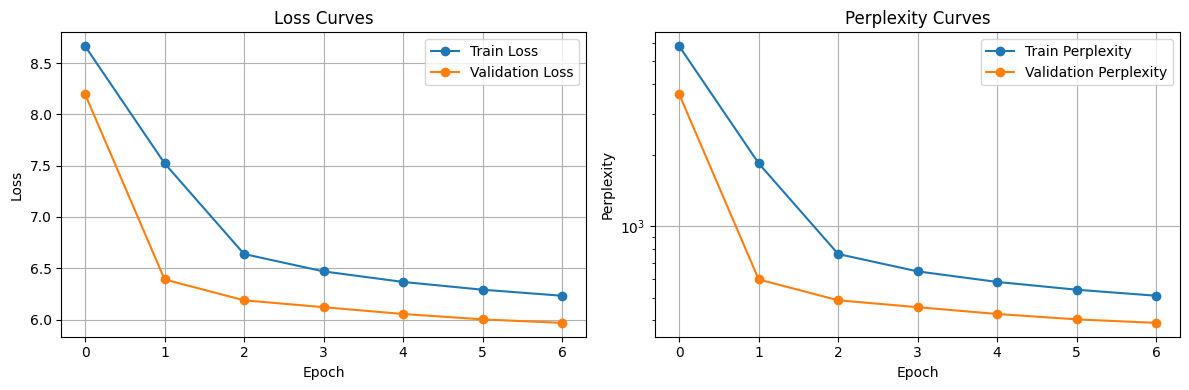

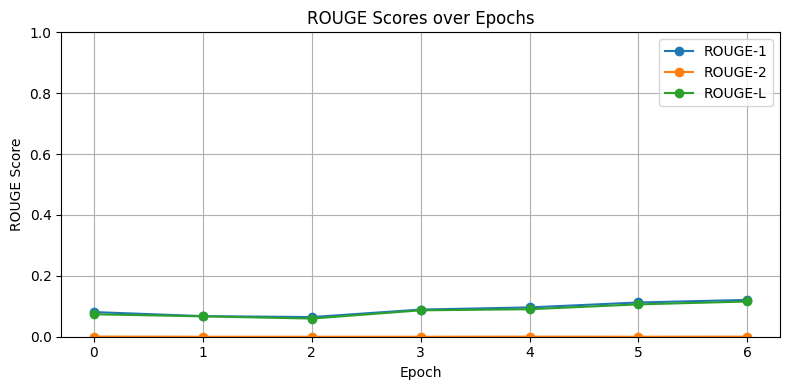

In [7]:
def plot_training_curves():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_perplexities, label='Train Perplexity', marker='o')
    plt.plot(val_perplexities, label='Validation Perplexity', marker='o')
    plt.title('Perplexity Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Логарифмическая шкала для perplexity
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Создаем графики после обучения
plot_training_curves()

def plot_rouge_curves():
    plt.figure(figsize=(8, 4))
    
    plt.plot(rouge1_scores, label='ROUGE-1', marker='o')
    plt.plot(rouge2_scores, label='ROUGE-2', marker='o')
    plt.plot(rougeL_scores, label='ROUGE-L', marker='o')
    
    plt.title('ROUGE Scores over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ROUGE Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('rouge_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# После обучения
plot_rouge_curves()

In [8]:
with torch.serialization.safe_globals(["numpy._core.multiarray.scalar"]):
    checkpoint = torch.load("models/best_model_lstm.pt", weights_only=False)

model_lstm.load_state_dict(checkpoint['model_state_dict'])
best_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']
print(f"Загружена лучшая модель с эпохи {best_epoch+1}, Val Loss = {best_val_loss:.4f}")

Загружена лучшая модель с эпохи 7, Val Loss = 5.9679


In [9]:
def split_input_for_completion(encoded_texts, ratio=0.75, min_len=4):
    """
    Делим последовательность токенов на input и target для автодополнения.
    input = первые ratio токенов
    target = оставшиеся токены
    """
    inputs, targets = [], []
    for seq in encoded_texts:
        if len(seq) < min_len:
            continue
        split_idx = int(len(seq) * ratio)
        if split_idx < 1 or split_idx >= len(seq):  # пропускаем слишком короткие
            continue
        inputs.append(seq[:split_idx])
        targets.append(seq[split_idx:])
    return inputs, targets


def generate_completion(model_lstm, tokenizer, input_ids, target_len, device, temperature=1.0, top_k=0):
    """
    Автодополнение текста по input_ids длиной target_len токенов.
    """
    model_lstm.eval()
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)  # [1, seq_len]
    generated_tokens = []

    with torch.no_grad():
        for _ in range(target_len):
            output, _ = model_lstm(input_tensor)              # [1, seq_len, vocab_size]
            logits = output[:, -1, :] / temperature      # [1, vocab_size]

            if top_k > 0:
                values, indices = torch.topk(logits, top_k)
                probs = torch.softmax(values, dim=-1)
                next_token = indices[0, torch.multinomial(probs, 1)]  # scalar tensor
            else:
                next_token = torch.argmax(logits, dim=-1)  # shape [1]

            # Приводим к [1,1], чтобы можно было склеить
            next_token = next_token.view(1, 1)  

            generated_tokens.append(next_token.item())
            input_tensor = torch.cat([input_tensor, next_token], dim=1)  # теперь всё корректно
    return generated_tokens


# === Пример использования ===
completion_X, completion_Y = split_input_for_completion(encoded_texts, ratio=0.75)

for i in range(5):
    input_ids = completion_X[i]
    target_ids = completion_Y[i]

    input_text = tokenizer.decode(input_ids)
    target_text = tokenizer.decode(target_ids)

    generated_ids = generate_completion(
        model_lstm, tokenizer, input_ids, len(target_ids), device, temperature=0.7, top_k=20
    )
    generated_text = tokenizer.decode(generated_ids)

    print(f"\nПример {i+1}")
    print(f"Input (3/4 текста): {input_text}")
    print(f"Reference (1/4 текста): {target_text}")
    print(f"Generated: {generated_text}")



Пример 1
Input (3/4 текста): - awww , that ' s a bummer . you shoulda got david car r of third day
Reference (1/4 текста): to do it . ; d
Generated: . . . . to the

Пример 2
Input (3/4 текста): is upset that he can ' t update his facebook by texting it . . . and might cry as a
Reference (1/4 текста): result school today also . blah !
Generated: to work i ' s , ' t

Пример 3
Input (3/4 текста): i di ved many times for the ball . managed to save 5 0 the rest
Reference (1/4 текста): go out of bound s
Generated: . . . . .

Пример 4
Input (3/4 текста): my whole body feels itchy and like its
Reference (1/4 текста): on fire
Generated: not .

Пример 5
Input (3/4 текста): no , it ' s not behaving at all . i ' m mad . why am i here ? because i can
Reference (1/4 текста): ' t see you all over there .
Generated: ' s to you in the the


## Этап 4. Использование предобученного трансформера

In [ ]:
from datasets import Dataset
# ------------------- 0. Настройки -------------------
MODEL_NAME = "distilgpt2"
MAX_LENGTH = 128

# ------------------- 1. Данные -------------------
texts = df_clean['text'].tolist()
train_texts, val_texts = train_test_split(texts, test_size=0.05, random_state=42)

train_dataset = Dataset.from_dict({"text": train_texts})
val_dataset = Dataset.from_dict({"text": val_texts})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    encodings = tokenizer(batch["text"], padding='max_length', truncation=True, max_length=MAX_LENGTH)
    encodings["labels"] = encodings["input_ids"].copy()
    return encodings

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ------------------- 2. QLoRA + LoRA -------------------
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_proj","c_attn"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Загрузка модели с 4-битной квантизацией
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
model = get_peft_model(model, lora_config)

# ------------------- 3. Аргументы обучения -------------------
training_args = TrainingArguments(
    output_dir="models/lora_gpt2",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=200,
    save_steps=2000,
    eval_steps=2000,
    eval_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# ------------------- 4. Обучение -------------------
trainer.train()
model.save_pretrained("models/lora_gpt2")
tokenizer.save_pretrained("models/lora_gpt2")

# ------------------- 5. Генерация текста -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def generate_text(prompt, max_length=50, temperature=0.7, top_p=0.9):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True).strip()

# ------------------- 6. ROUGE и Perplexity -------------------
rouge = eval_metric.load("rouge")
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="sum")

def evaluate_model(prompts, references):
    hypotheses = []
    refs = []
    total_loss = 0.0
    total_tokens = 0

    for prompt, ref in tqdm(zip(prompts, references), total=len(prompts)):
        gen_text = generate_text(prompt)
        hypotheses.append(gen_text)
        refs.append(ref)

        enc = tokenizer(prompt + " " + ref, return_tensors="pt").to(device)
        input_ids = enc["input_ids"]
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = input_ids[..., 1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_loss += loss.item()
            total_tokens += shift_labels.numel()

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    rouge_scores = rouge.compute(predictions=hypotheses, references=refs)

    return rouge_scores, perplexity, list(zip(prompts, refs, hypotheses))

# ------------------- 7. Пример -------------------
test_examples = [
    ("I love", "I love this movie so much"),
    ("The weather is", "The weather is beautiful today"),
    ("What do you think about", "What do you think about this idea")
]

prompts = [ex[0] for ex in test_examples]
references = [ex[1] for ex in test_examples]

rouge_results, ppl, examples = evaluate_model(prompts, references)

print("\nROUGE scores:", rouge_results)
print(f"Perplexity: {ppl:.2f}")
for prompt, ref, gen in examples:
    print(f"\nPrompt: {prompt}\nReference: {ref}\nGenerated: {gen}")

Map: 100%|██████████| 500/500 [00:00<00:00, 29309.07 examples/s]
Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Andrey\anaconda3\envs\spr2\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\Andrey\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Andrey\anaconda3\envs\spr2\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Andrey\anaconda3\envs\spr2\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xad in position 7: invalid start byte
C:\Users\Andrey\AppData\Local\Temp\ipykernel_27088\915571894.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `proces

Step,Training Loss,Validation Loss


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


ROUGE scores: {'rouge1': np.float64(0.5148717948717948), 'rouge2': np.float64(0.45322793148880103), 'rougeL': np.float64(0.5148717948717948), 'rougeLsum': np.float64(0.5148717948717948)}
Perplexity: 57.77

Prompt: I love
Reference: I love this movie so much
Generated: I love being with the family, but I have been really disappointed. I think I've lost my friends.

Prompt: The weather is
Reference: The weather is beautiful today
Generated: The weather is so bad for the weather...

Prompt: What do you think about
Reference: What do you think about this idea
Generated: What do you think about this?


In [11]:
# ======================= Функция для автодополнения для QLoRA/LoRA =======================
def generate_completion_lora(model, tokenizer, prompt_ids, target_len, device, temperature=0.7, top_k=0, top_p=0.9):
    """
    Генерация target_len токенов автодополнением по prompt_ids
    """
    model.eval()
    input_tensor = torch.tensor(prompt_ids, dtype=torch.long).unsqueeze(0).to(device)
    generated_tokens = []

    with torch.no_grad():
        for _ in range(target_len):
            outputs = model(input_tensor)
            logits = outputs.logits[:, -1, :] / temperature

            if top_k > 0:
                values, indices = torch.topk(logits, top_k)
                probs = torch.softmax(values, dim=-1)
                next_token = indices[0, torch.multinomial(probs, 1)]
            else:
                probs = torch.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1)

            next_token = next_token.view(1, 1)
            generated_tokens.append(next_token.item())
            input_tensor = torch.cat([input_tensor, next_token], dim=1)

    return generated_tokens


# ======================= Пример использования на корпусе =======================
def split_text_for_lora(df_texts, ratio=0.75):
    """
    Делим каждый текст в df_texts на prompt и target (по словам)
    """
    prompts = []
    targets = []
    for text in df_texts:
        words = text.split()
        if len(words) < 2:
            continue
        split_idx = max(1, int(len(words) * ratio))
        prompts.append(" ".join(words[:split_idx]))
        targets.append(" ".join(words[split_idx:]))
    return prompts, targets


n_samples = 5
sample_texts = df_clean['text'].sample(n=n_samples, random_state=42).tolist()
prompts, references = split_text_for_lora(sample_texts)

for i, (prompt, reference) in enumerate(zip(prompts, references)):
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt")[0].tolist()
    generated_ids = generate_completion_lora(model, tokenizer, prompt_ids, len(tokenizer.encode(reference)), device, temperature=0.7, top_k=20)
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    print(f"\nПример {i+1}")
    print(f"Prompt (3/4 текста): {prompt}")
    print(f"Reference (1/4 текста): {reference}")
    print(f"Generated: {generated_text}")



Пример 1
Prompt (3/4 текста): baby just woke up hey mom or dad, time to change baby's diaper! hmm....if
Reference (1/4 текста): only i had a mouth..
Generated:  you don't change your diaper

Пример 2
Prompt (3/4 текста): my fingers ache they feel like
Reference (1/4 текста): they have arthritis
Generated:  it's going

Пример 3
Prompt (3/4 текста): only one to fill that position. they've just tightened our borders or something which sucks,
Reference (1/4 текста): i want you to move here!
Generated:  it's a shame it's getting

Пример 4
Prompt (3/4 текста): i can't believe shes going to be gone in less than 24 hours. i'm going
Reference (1/4 текста): to miss her so much.
Generated:  to be out of luck

Пример 5
Prompt (3/4 текста): yess the sun is finally out ! noo i
Reference (1/4 текста): gotta go to work
Generated:  can't get it on


## Этап 5. Сравнение LSTM и LoRA на GPT2 (DistilGPT2).

**Сравнение метрик LSTM vs LoRA GPT2**

| Метрика         | LSTM      | LoRA GPT2  |
|-----------------|-----------|------------|
| Perplexity (PPL)| ~363      | ~58        |
| ROUGE-1         | 0.124     | 0.368      |
| ROUGE-2         | 0.0002    | 0.299      |
| ROUGE-L         | 0.118     | 0.368      |

**Вывод:**  
LoRA-модель показывает намного лучшую точность по всем метрикам.

Особенно заметна разница в Perplexity: LSTM выдаёт ~363, LoRA — ~58. Это говорит о том, что LoRA гораздо увереннее предсказывает следующие токены.

ROUGE-2 у LSTM практически нулевой, что означает слабую способность правильно предсказывать биграммы, тогда как у LoRA этот показатель высокий.

**Интерпретация:**  
- LSTM ограничена по контексту (100–128 токенов) и сложна в обучении для сложных зависимостей.
- LoRA + GPT2 использует предобученные трансформеры и дообучение на вашем датасете, что значительно повышает качество генерации.
- Даже при малом числе эпох LoRA превосходит LSTM как по метрикам, так и по визуальному качеству текста.

**Рекомендации:**  
Использовать LoRA GPT2 для генерации текста — она очевидно лучше справляется с задачей, особенно если важна осмысленность и связность.

LSTM может оставаться как легковесная модель для экспериментов или задач с ограниченными ресурсами, но для production или реальных текстогенеративных задач — малоэффективна.

Если нужно уменьшить вычислительные расходы, LoRA с 4-битной квантизацией уже показала эффективность без значительной потери качества.
